Q1 Summary: {'original_mentions_total': 29320, 'original_mentions_with_mapped_retrdate': 28988, 'original_mentions_after_retraction': 14456, 'share_after_retraction': np.float64(0.4986891127363047), 'unique_doi_with_post_retr_original_mentions': 4787}


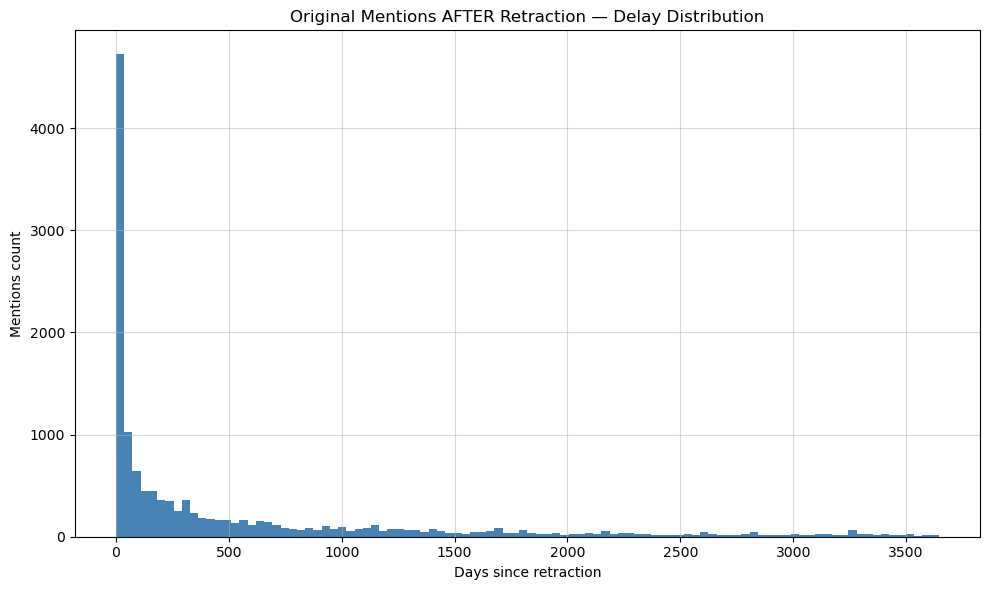

Q2 Mention-level: {'n_nonneg_mentions': 12729, 'median_nonneg_delay_days': np.float64(40.0), 'p10_nonneg_delay_days': np.float64(1.0), 'p90_nonneg_delay_days': np.float64(1234.4000000000015)}
Q2 Title-level: {'n_doi_with_post_retr_coverage': 5753, 'median_first_post_delay_days': np.float64(18.0), 'p10_first_post_delay_days': np.float64(0.0), 'p90_first_post_delay_days': np.float64(673.8000000000002)}


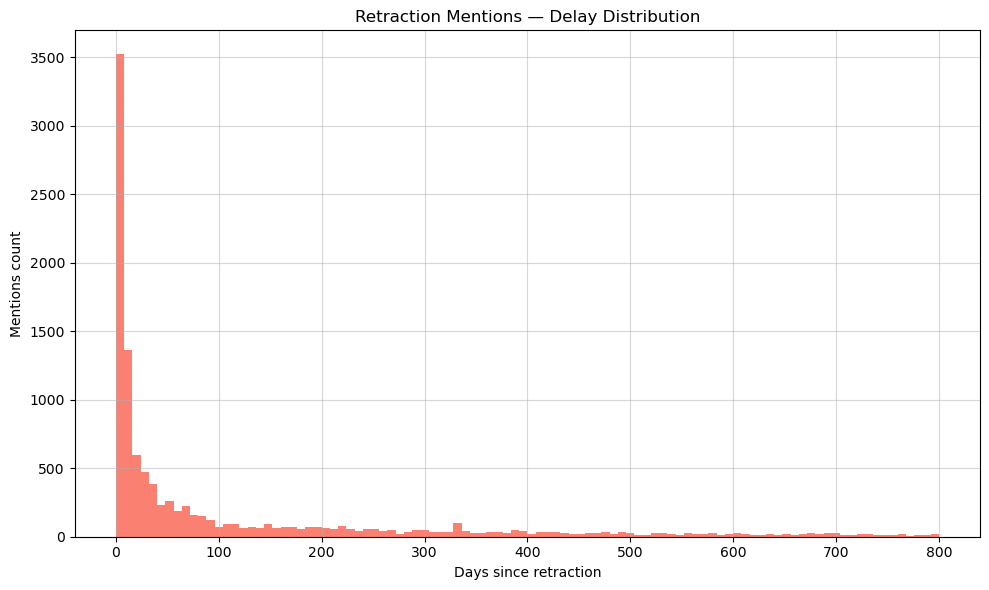

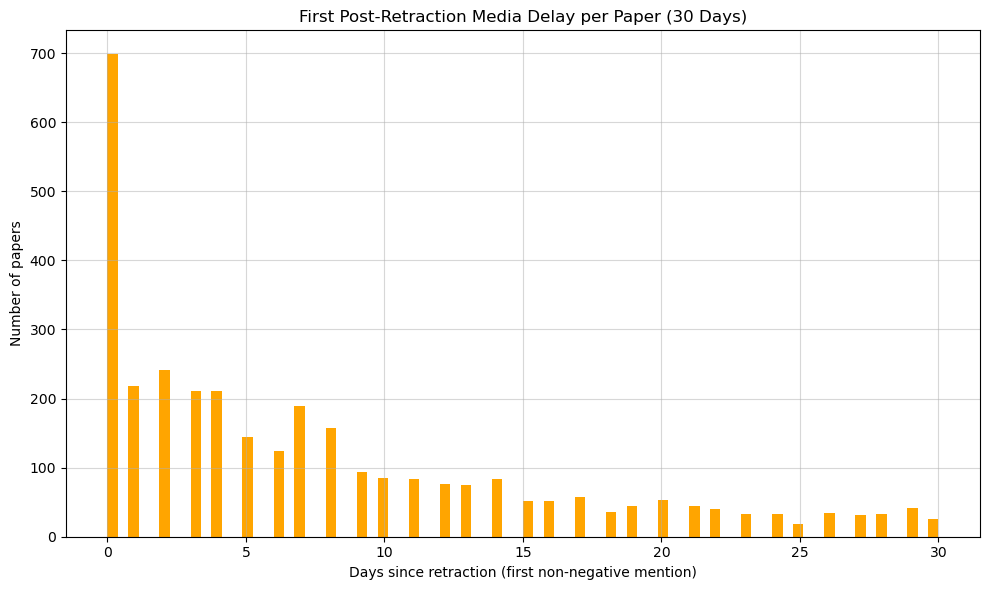

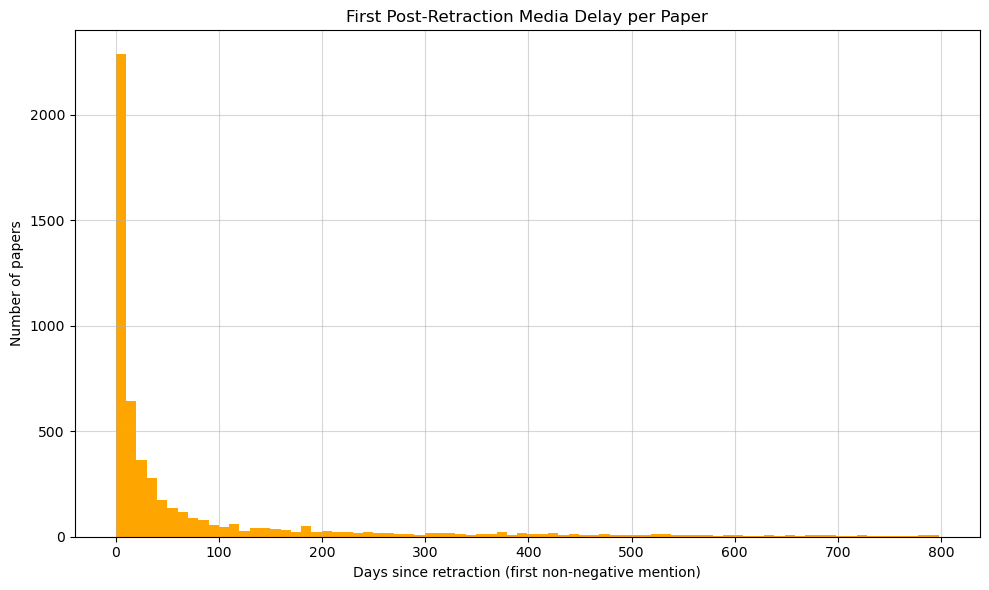

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PATH_MASTER = "dataset_14_08_2025_completion.csv"
PATH_ORIG   = "mentions_original_fill_cleaned.csv"
PATH_RETR   = "mentions_retraction_fill_cleaned.csv"
OUT = Path("analysis_outputs")
OUT.mkdir(exist_ok=True)

def norm_str(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    return np.nan if x in ["", "0", "nan", "None", "null", "Null"] else x

def norm_doi(x):
    x = norm_str(x)
    if pd.isna(x): return np.nan
    x = x.lower().strip()
    return x[4:].strip() if x.startswith("doi:") else x

master = pd.read_csv(PATH_MASTER, dtype=str, keep_default_na=False, na_values=[])
for c in ["OriginalPaperDate","RetractionDate"]:
    master[c] = pd.to_datetime(master[c], errors="coerce", utc=True)
master["orig_doi_norm"] = master.get("OriginalPaperDOI").map(norm_doi)
master["retr_doi_norm"] = master.get("RetractionDOI").map(norm_doi)

map_origdoi_to_retrdate = (
    master.dropna(subset=["orig_doi_norm","RetractionDate"])
          .groupby("orig_doi_norm")["RetractionDate"].min()
)
map_retrdoi_to_retrdate = (
    master.dropna(subset=["retr_doi_norm","RetractionDate"])
          .groupby("retr_doi_norm")["RetractionDate"].min()
)

orig = pd.read_csv(PATH_ORIG, dtype=str, keep_default_na=False, na_values=[])
retr = pd.read_csv(PATH_RETR, dtype=str, keep_default_na=False, na_values=[])

for df in (orig, retr):
    df["Mention Date"] = pd.to_datetime(df["Mention Date"], errors="coerce", utc=True)
    df["doi_norm"] = df.get("DOI").map(norm_doi)


o2 = orig.copy()
o2["RetractionDate_mapped"] = o2["doi_norm"].map(map_origdoi_to_retrdate)
q1_df = o2.dropna(subset=["RetractionDate_mapped","Mention Date"]).copy()
q1_df["delay_from_retraction_days"] = (q1_df["Mention Date"] - q1_df["RetractionDate_mapped"]).dt.days
q1_df["post_retraction_citation"] = q1_df["delay_from_retraction_days"] >= 0


q1_counts = {
    "original_mentions_total": len(orig),
    "original_mentions_with_mapped_retrdate": len(q1_df),
    "original_mentions_after_retraction": int(q1_df["post_retraction_citation"].sum()),
    "share_after_retraction": q1_df["post_retraction_citation"].mean(),
    "unique_doi_with_post_retr_original_mentions": q1_df.loc[q1_df["post_retraction_citation"], "doi_norm"].nunique()
}
print("Q1 Summary:", q1_counts)


vals = q1_df.loc[q1_df["post_retraction_citation"], "delay_from_retraction_days"].astype(int).values
if vals.size:
    vals = vals[(vals>=0) & (vals<=3650)]
    plt.figure(figsize=(10,6))
    plt.hist(vals, bins=100, color="steelblue")
    plt.title("Original Mentions AFTER Retraction — Delay Distribution")
    plt.xlabel("Days since retraction")
    plt.ylabel("Mentions count")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(OUT/"q1_post_retr_original_delay_hist.png")
    plt.show()


r2 = retr.copy()
r2["RetractionDate_mapped"] = r2["doi_norm"].map(map_retrdoi_to_retrdate)
q2_df = r2.dropna(subset=["RetractionDate_mapped","Mention Date"]).copy()
q2_df["delay_days"] = (q2_df["Mention Date"] - q2_df["RetractionDate_mapped"]).dt.days


mention_nonneg = q2_df.loc[q2_df["delay_days"]>=0, "delay_days"].astype(int).values
q2_mention_stats = {
    "n_nonneg_mentions": len(mention_nonneg),
    "median_nonneg_delay_days": np.median(mention_nonneg),
    "p10_nonneg_delay_days": np.percentile(mention_nonneg,10),
    "p90_nonneg_delay_days": np.percentile(mention_nonneg,90),
}
print("Q2 Mention-level:", q2_mention_stats)

per_doi = (
    q2_df.groupby("doi_norm")["delay_days"]
         .apply(lambda s: int(s[s>=0].min()) if (s>=0).any() else np.nan)
         .dropna()
)
q2_title_stats = {
    "n_doi_with_post_retr_coverage": per_doi.shape[0],
    "median_first_post_delay_days": np.median(per_doi),
    "p10_first_post_delay_days": np.percentile(per_doi,10),
    "p90_first_post_delay_days": np.percentile(per_doi,90),
}
print("Q2 Title-level:", q2_title_stats)


if mention_nonneg.size:
    vals = mention_nonneg[(mention_nonneg>=0)&(mention_nonneg<=800)]
    plt.figure(figsize=(10,6))
    plt.hist(vals, bins=100, color="salmon")
    plt.title("Retraction Mentions — Delay Distribution")
    plt.xlabel("Days since retraction")
    plt.ylabel("Mentions count")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(OUT/"q2_retr_mentions_delay_hist.png")
    plt.show()

if per_doi.size:
    vals = per_doi[(per_doi>=0)&(per_doi<=30)]
    plt.figure(figsize=(10,6))
    plt.hist(vals, bins=80, color="orange")
    plt.title("First Post-Retraction Media Delay per Paper (30 Days)")
    plt.xlabel("Days since retraction (first non-negative mention)")
    plt.ylabel("Number of papers")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(OUT/"q2_first_post_retr_delay_hist.png")
    plt.show()

if per_doi.size:
    vals = per_doi[(per_doi>=0)&(per_doi<=800)]
    plt.figure(figsize=(10,6))
    plt.hist(vals, bins=80, color="orange")
    plt.title("First Post-Retraction Media Delay per Paper")
    plt.xlabel("Days since retraction (first non-negative mention)")
    plt.ylabel("Number of papers")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(OUT/"q2_first_post_retr_delay_hist.png")
    plt.show()

Pre-retraction mentions: 14532
Post-retraction mentions: 14456
Chi-square test: chi2=0.094, p=7.586e-01
Binomial test vs 0 proportion: BinomTestResult(k=14456, n=28988, alternative='greater', statistic=0.4986891127363047, pvalue=0.0)


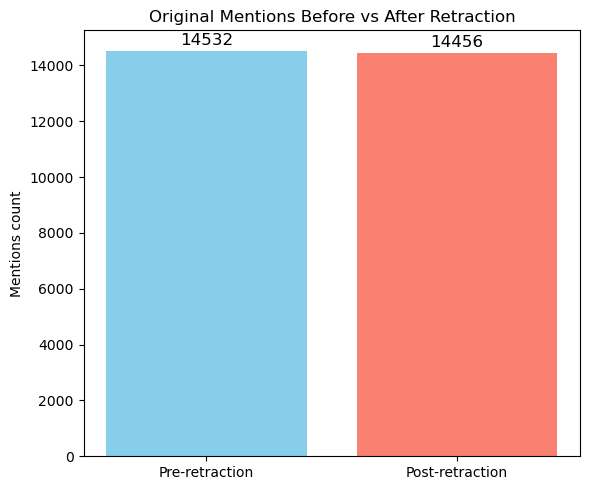

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, binomtest

df = q1_df.copy()  

counts = df["post_retraction_citation"].value_counts()
n_post = counts.get(True, 0)
n_pre = counts.get(False, 0)

print("Pre-retraction mentions:", n_pre)
print("Post-retraction mentions:", n_post)


table = [[n_pre, n_post]]
chi2, p_chi, dof, expected = chi2_contingency([table[0],[expected:=sum(table[0])/2,sum(table[0])/2]])


print(f"Chi-square test: chi2={chi2:.3f}, p={p_chi:.3e}")

binom_res = binomtest(n_post, n_pre+n_post, p=0.0, alternative="greater")
print("Binomial test vs 0 proportion:", binom_res)


plt.figure(figsize=(6,5))
plt.bar(["Pre-retraction","Post-retraction"], [n_pre,n_post], color=["skyblue","salmon"])
plt.ylabel("Mentions count")
plt.title("Original Mentions Before vs After Retraction")
for i,val in enumerate([n_pre,n_post]):
    plt.text(i, val+200, str(val), ha="center", fontsize=12)
plt.tight_layout()
plt.savefig("analysis_outputs/q1_pre_vs_post_bar.png")
plt.show()